In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score,ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTENC,BorderlineSMOTE,SMOTE
import openpyxl


pd.options.mode.copy_on_write = True

In [2]:
df = pd.read_csv('fraudTrain.csv')

In [3]:
df_test = pd.read_csv('fraudTest.csv')

### Target Encoding

In [4]:
df.dropna(axis=0, how='any',inplace=True)

In [5]:
cat_targ_enc = df.groupby('category')['is_fraud'].mean()
df['category_target_enc'] = df['category'].map(cat_targ_enc)

In [6]:
merchant_targ_enc = df.groupby('merchant')['is_fraud'].mean()
df['merchant_target_enc'] = df['merchant'].map(merchant_targ_enc)

<Axes: xlabel='is_fraud', ylabel='category_target_enc'>

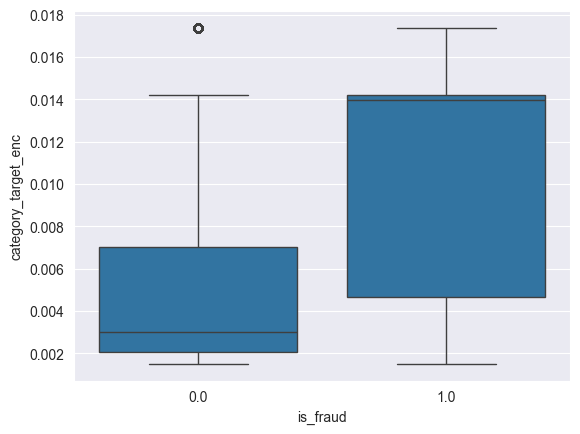

In [7]:
sns.boxplot(x= df['is_fraud'],y=df['category_target_enc'])

In [ ]:
sns.boxplot(x= df['is_fraud'],y=df['merchant_target_enc'])

#### Testing Set

In [8]:
df_test['category_target_enc'] = df_test['category'].map(cat_targ_enc)
df_test['merchant_target_enc'] = df_test['merchant'].map(merchant_targ_enc)

# Pre-Processing Features

### *Time* Feature

In [9]:
df['Time'] = pd.to_datetime(df['Time'])

In [10]:
df_test['Time'] = pd.to_datetime(df_test['Time'])

In [11]:
df['Time:year'] = df['Time'].dt.year
df['Time:month'] = df['Time'].dt.month
df['Time:day'] = df['Time'].dt.day
df['Time:hour'] = df['Time'].dt.hour

In [12]:
df_test['Time:year'] = df_test['Time'].dt.year
df_test['Time:month'] = df_test['Time'].dt.month
df_test['Time:day'] = df_test['Time'].dt.day
df_test['Time:hour'] = df_test['Time'].dt.hour

In [13]:
df.drop(columns=['ID','trans_num','Time','firstName','lastName'], inplace=True)

In [14]:
df_test.drop(columns=['ID','trans_num','Time','firstName','lastName'], inplace=True)

In [15]:
df.dtypes

Card Number            float64
merchant                object
category                object
Amount                 float64
is_fraud               float64
category_target_enc    float64
merchant_target_enc    float64
Time:year                int32
Time:month               int32
Time:day                 int32
Time:hour                int32
dtype: object

In [16]:
df_test.dtypes

Card Number            float64
merchant                object
category                object
Amount                 float64
is_fraud                 int64
category_target_enc    float64
merchant_target_enc    float64
Time:year                int32
Time:month               int32
Time:day                 int32
Time:hour                int32
dtype: object

In [17]:
df.drop(columns=['merchant','category'],inplace =True)
df_test.drop(columns=['merchant','category'],inplace=True)

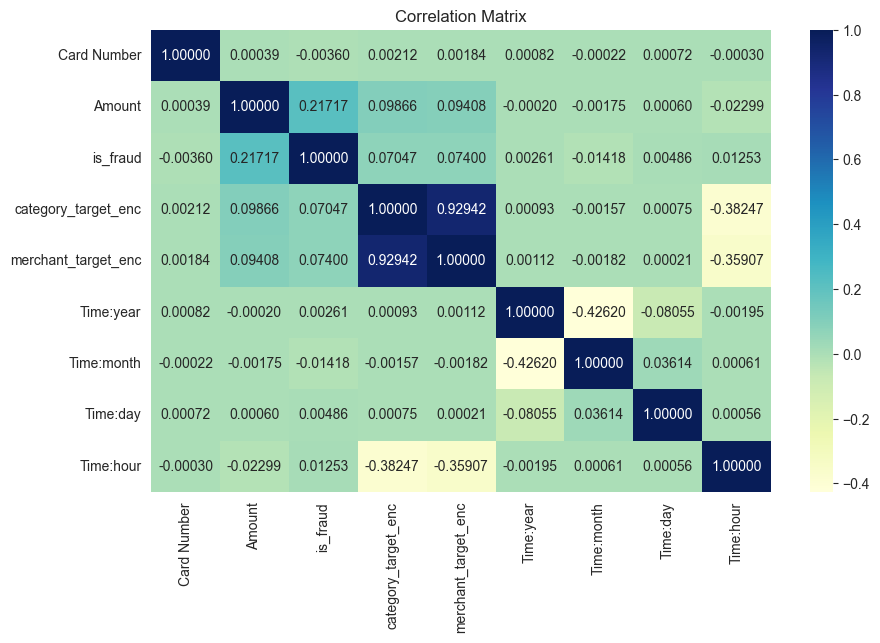

In [18]:
corr_matrix = df.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix,annot=True,cmap='YlGnBu',fmt='.5f')
plt.title('Correlation Matrix')
plt.show()

### *Amount* Feature

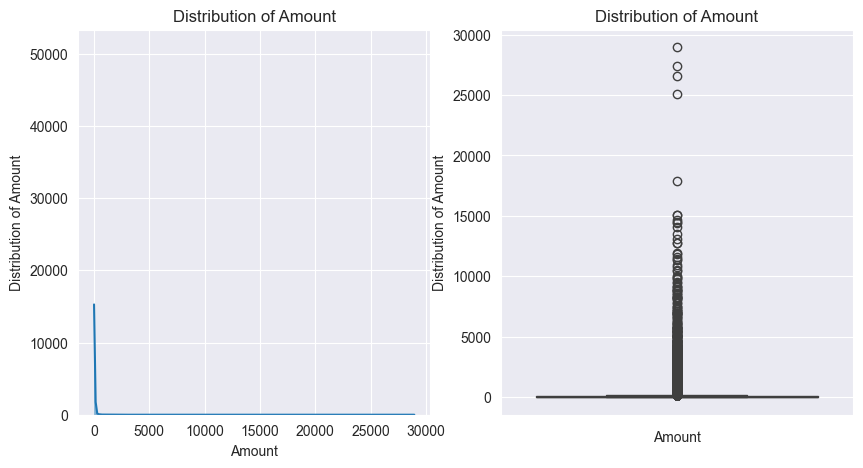

In [19]:
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.histplot(ax=ax1,data=df['Amount'], kde=True)
ax1.set_title('Distribution of Amount')
ax1.set_xlabel('Amount')
ax1.set_ylabel('Distribution of ' + 'Amount')
sns.boxplot(data=df['Amount'])
ax2.set_title('Distribution of Amount')
ax2.set_xlabel('Amount')
ax2.set_ylabel('Distribution of ' + 'Amount')
plt.show()

In [ ]:
#z_scores = (df['Amount'] - np.mean(df['Amount'])) / np.std(df['Amount'])
#df = df[np.abs(z_scores) <= 3]

In [ ]:
#fig1, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
#sns.histplot(ax=ax1,data=df['Amount'], kde=True)
#ax1.set_title('Distribution of Amount')
#ax1.set_xlabel('Amount')
#ax1.set_ylabel('Distribution of ' + 'Amount')
#sns.boxplot(data=df['Amount'])
#ax2.set_title('Distribution of Amount')
#ax2.set_xlabel('Amount')
#ax2.set_ylabel('Distribution of ' + 'Amount')
#plt.show()

In [20]:
df['log_amount'] = np.log(df['Amount'])

In [21]:
df_test['log_amount'] = np.log(df_test['Amount'])

In [ ]:
fig2, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
sns.histplot(ax=ax1,data=df['log_amount'], kde=True)
ax1.set_title('Distribution of Amount')
ax1.set_xlabel('Amount')
ax1.set_ylabel('Distribution of ' + 'Amount')
sns.boxplot(data=df['log_amount'])
ax2.set_title('Distribution of Amount')
ax2.set_xlabel('Amount')
ax2.set_ylabel('Distribution of ' + 'Amount')
plt.show()

In [22]:
df.drop(columns='Amount',inplace=True)

In [23]:
df_test.drop(columns='Amount',inplace=True)

In [24]:
df.dtypes

Card Number            float64
is_fraud               float64
category_target_enc    float64
merchant_target_enc    float64
Time:year                int32
Time:month               int32
Time:day                 int32
Time:hour                int32
log_amount             float64
dtype: object

In [25]:
df_test.dtypes

Card Number            float64
is_fraud                 int64
category_target_enc    float64
merchant_target_enc    float64
Time:year                int32
Time:month               int32
Time:day                 int32
Time:hour                int32
log_amount             float64
dtype: object

### Applying *OverSampling & UnderSampling*

In [26]:
X = df.drop('is_fraud',axis = 1)
y = df['is_fraud']

In [27]:
X_test = df_test.drop('is_fraud',axis = 1)
y_test = df_test['is_fraud']

In [28]:
border_smote = BorderlineSMOTE(sampling_strategy=1,random_state=42)
smote = SMOTE(sampling_strategy=1,random_state=42)
X_resampled, y_resampled = smote.fit_resample(X,y)

In [29]:
X_resampled.dtypes

Card Number            float64
category_target_enc    float64
merchant_target_enc    float64
Time:year                int32
Time:month               int32
Time:day                 int32
Time:hour                int32
log_amount             float64
dtype: object

In [30]:
y_resampled.value_counts()

is_fraud
0.0    996390
1.0    996390
Name: count, dtype: int64

# Random Forest

# XGBoost

In [31]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',random_state=42)

In [32]:
xgb_model.fit(X_resampled,y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [33]:
xgb_predictions = xgb_model.predict(X_test)

In [34]:
xgb_Accuracy_Score = accuracy_score(y_test, xgb_predictions)
xgb_F1_Score = f1_score(y_test, xgb_predictions)
xgb_Confusion_Matrix = confusion_matrix(y_test,xgb_predictions)
xgb_Recall = recall_score(y_test,xgb_predictions)
xgb_Precision = precision_score(y_test,xgb_predictions)
xgb_roc_auc_score = roc_auc_score(y_test,xgb_predictions)

xgb_scores = [(xgb_Recall,xgb_Precision,xgb_Accuracy_Score,xgb_F1_Score,xgb_roc_auc_score)]
xgb_df = pd.DataFrame(data = xgb_scores,columns=['Recall','Precision','Accuracy','F1','ROC-AUC'])
xgb_df.insert(0,'Model','XGB')
xgb_df

,Model,Recall,Precision,Accuracy,F1,ROC-AUC
0,XGB,0.770163,0.511455,0.996273,0.614698,0.883656


In [35]:
import pickle

# Saving the model
columns_after_encoding = X.columns.tolist()


with open('xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)
with open('cat_targ_enc.pkl', 'wb') as file:
    pickle.dump(cat_targ_enc, file)
with open('merchant_targ_enc.pkl', 'wb') as file:
    pickle.dump(merchant_targ_enc, file)
with open('columns_after_encoding.pkl', 'wb') as file:
    pickle.dump(columns_after_encoding, file)
    


    